# Prostate cancer prediction 

#### Data

We consider a medical study conducted on 97 men with prostate cancer.
The focus is on the relationship between the prostate specific antigen (psa), which is elevated in men with prostate cancer, and others clinical measures. 
The others clinical measures are the predictors variables, gathered in a medical examination, and the amount of expression of the antigen associated with the cancer detection is the response variable (lpsa).

Thus the data frame is made of 97 observations on 9 variables:
* lcavol: log cancer volume
* lweight: log prostate weight
* age: patient age in years
* lbph: log amount of benign prostatic hyperplasia
* svi: seminal vesicle invasion
* lcp: log of capsular penetration
* gleason: Gleason score
* pgg45: percent of Gleason score 4 or 5
* lpsa: log prostate specific antigen

The goal is to find models predicting the response lpsa.

#### Models

The data are represented by $n$ points in $p$ dimensions, thus the predictor variable is written $X\in\mathbb{R}^{n\times p}$ and the response variable is $y\in\mathbb{R}^n$.

In this work, we're insterested in the relationship between the predictor $X$ and the response $y$.
To determine this relationship, we adopt regression models.
The standard baseline is achieved with linear regression and we compare results for regularized regressions: **Ridge regression**, **Lasso** and **Elastic Net**.

In [11]:
import numpy as np
import pandas as pd
from sklearn import linear_model, metrics, model_selection
from sklearn.linear_model import ElasticNet
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
import seaborn as sns
import statsmodels.api as sm

## Data exploration

In [12]:
lpsa_data = pd.read_csv('data/prostate_dataset.txt', delimiter='\t')
lpsa_data.drop(columns=['col'], inplace=True)

In [13]:
lpsa_data.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
0,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783
1,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519
2,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519
3,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519
4,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564


In [14]:
lpsa_data.corr()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
lcavol,1.000000,0.280521,0.225000,0.027350,0.538845,0.675310,0.432417,0.433652,0.734460
lweight,0.280521,1.000000,0.347969,0.442264,0.155385,0.164537,0.056882,0.107354,0.433319
age,0.225000,0.347969,1.000000,0.350186,0.117658,0.127668,0.268892,0.276112,0.169593
lbph,0.027350,0.442264,0.350186,1.000000,-0.085843,-0.006999,0.077820,0.078460,0.179809
svi,0.538845,0.155385,0.117658,-0.085843,1.000000,0.673111,0.320412,0.457648,0.566218
lcp,0.675310,0.164537,0.127668,-0.006999,0.673111,1.000000,0.514830,0.631528,0.548813
gleason,0.432417,0.056882,0.268892,0.077820,0.320412,0.514830,1.000000,0.751905,0.368987
pgg45,0.433652,0.107354,0.276112,0.078460,0.457648,0.631528,0.751905,1.000000,0.422316
lpsa,0.734460,0.433319,0.169593,0.179809,0.566218,0.548813,0.368987,0.422316,1.000000


* The more correlated variable with the response lpsa is lcavol.
  Thus in a data analysis, the lcavol variable must be included as a predictor.

* The correlation matrix shows that gleason and pgg45 are actually correlated. 
  Indeed, the variable pgg45 measures the percentage of 4 or 5 Gleason scores that were recorded before the final current Gleason score.

Let plot the relationship between the response lpsa and the lcavol feature.

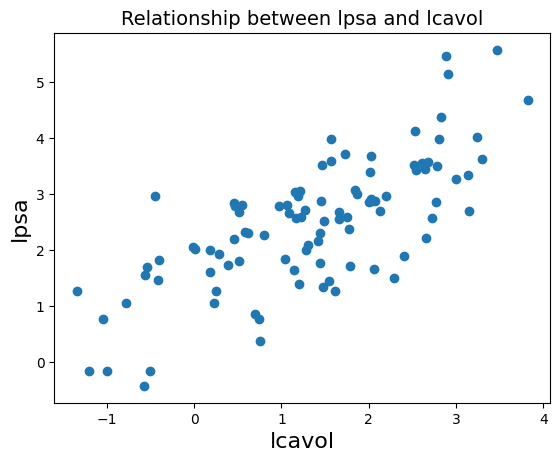

In [15]:
plt.scatter(lpsa_data['lcavol'], lpsa_data['lpsa'])
plt.xlabel('lcavol', fontsize=16)
plt.ylabel('lpsa', fontsize=16)
plt.title("Relationship between lpsa and lcavol", fontsize=14)
plt.show()

There is a pretty clear linear relationship with positive correlation, as seen on the correlation matrix.

### Data train/test splitting

In [16]:
lpsa_data.describe()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000
mean,1.350010,3.628943,63.865979,0.100356,0.216495,-0.179366,6.752577,24.381443,2.478387
std,1.178625,0.428411,7.445117,1.450807,0.413995,1.398250,0.722134,28.204035,1.154329
min,-1.347074,2.374906,41.000000,-1.386294,0.000000,-1.386294,6.000000,0.000000,-0.430783
25%,0.512824,3.375880,60.000000,-1.386294,0.000000,-1.386294,6.000000,0.000000,1.731656
50%,1.446919,3.623007,65.000000,0.300105,0.000000,-0.798508,7.000000,15.000000,2.591516
75%,2.127041,3.876396,68.000000,1.558145,0.000000,1.178655,7.000000,40.000000,3.056357
max,3.821004,4.780383,79.000000,2.326302,1.000000,2.904165,9.000000,100.000000,5.582932


#### Como tenemos únicamente 97 observaciones, vamos a separar 60/37 para intentar tener volumen en train y test.

###### PD. Sale mal

In [17]:
# train : the first rows 
# test : the last rows 
n_split = 60
train = lpsa_data.iloc[:60]
test = lpsa_data.iloc[60:]

In [19]:
X_test = test.drop(columns=['lpsa'])
y_test = test['lpsa']

In [20]:
X_train = train.drop(columns=['lpsa'])
y_train = train['lpsa']

In [21]:
lr = linear_model.LinearRegression()

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

In [22]:
print("Train MSE:", metrics.mean_squared_error(y_train, lr.predict(X_train)))
print("Train RMSE:", np.sqrt(metrics.mean_squared_error(y_train, lr.predict(X_train))))
print("Test MSE:", metrics.mean_squared_error(y_test, lr.predict(X_test)))
print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, lr.predict(X_test))))

Train MSE: 0.286522449705847
Train RMSE: 0.5352779181937612
Test MSE: 2.820838873794865
Test RMSE: 1.6795353148400498


![Sin título.png](<attachment:Sin título.png>)
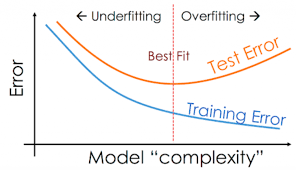

#### Ahora, lo haremos aleatoriamente

In [25]:
# train : the first rows 
# test : the last rows 
from sklearn.model_selection import train_test_split

# Esta vez, nuestro modelo serán el 80% de los datos y el test el 20% de los datos
X_train, X_test, y_train, y_test = train_test_split(lpsa_data.drop(columns=["lpsa"]), lpsa_data["lpsa"], test_size = 0.38, random_state = 42)

In [26]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(60, 8)
(37, 8)
(60,)
(37,)


In [27]:
lr = linear_model.LinearRegression()

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

In [29]:
# prediccion Train y test
lr = linear_model.LinearRegression()

lr.fit(X_train, y_train)

y_pred_T = lr.predict(X_train)

In [30]:
print("Train MSE:", metrics.mean_squared_error(y_train, lr.predict(X_train)))
print("Train RMSE:", np.sqrt(metrics.mean_squared_error(y_train, lr.predict(X_train))))
print("Test MSE:", metrics.mean_squared_error(y_test, lr.predict(X_test)))
print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, lr.predict(X_test))))

Train MSE: 0.46641709886601684
Train RMSE: 0.6829473617095367
Test MSE: 0.4556378245771581
Test RMSE: 0.6750094996199373


In [ ]:
# X_train y X_test... son realmente iguales?

In [ ]:
lpsa_data["lcavol_s"] = lpsa_data["lcavol"].astype(int)
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for train_index, test_index in split.split(lpsa_data, lpsa_data["lcavol_s"]):
    X_train = lpsa_data.iloc[train_index]
    X_test = lpsa_data.iloc[test_index]

In [ ]:
X_train.describe()

In [ ]:
X_test.describe()

In [ ]:
lpsa_data.drop(columns=["col"], inplace=True)

In [ ]:
y_train = X_train["lpsa"]
X_train.drop(columns=["lpsa", "lcavol_s"], inplace=True)

In [ ]:
y_test = X_test["lpsa"]
X_test.drop(columns=["lpsa", "lcavol_s"], inplace=True)

In [ ]:
X_train

# Learning models


# 1) Linear regression baseline

The linear regression attemps to model the relationship between the predictors variables $X$ and the response variable $y$.
It consists in finding a linear function $f:\mathbb{R}^p \to \mathbb{R}$ which predicts the response $y_i$ from the predictors $X_{i1},...,X_{ip}$ given $n$ observations for $i=1,...,n$.

In Python, the linear regression is implemented as  [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) in the linear_model module of scikit-learn.

In [ ]:
lr = linear_model.LinearRegression()

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
baseline_error = metrics.mean_squared_error(y_test, y_pred)

print("Train MSE:", metrics.mean_squared_error(y_train, lr.predict(X_train)))
print("Train RMSE:", np.sqrt(metrics.mean_squared_error(y_train, lr.predict(X_train))))
print("Test MSE:", metrics.mean_squared_error(y_test, lr.predict(X_test)))
print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, lr.predict(X_test))))

# 2) Regularization

In order to avoid over-learning, the regularization method allows to control the model complexity.
The model minimizes the error plus a regularization term $\lambda Reg(\beta)$ measuring the complexity, where $Reg(\beta)$ is a penalty term and $\lambda$ is an hyper-parameter.
The hyper-parameter controls the relative influence of the error term and the amount of regularization.
The optimal value of $\lambda$ can be found by cross validation (see repository [cross-validation](https://github.com/christelle-git/cross-validation/)). 

## 2.1) Ridge regression 

In the Ridge regression, the regularization term is $Reg(\beta) = ||\beta||_2^2$.
The Ridge regression allows to reduce the magnitude of the weights $\beta_i$ of the linear regression, and thus avoid over-learning.
The Ridge regression has a grouped selection effect: the correlated variables have the same weights.

In [ ]:
from sklearn.linear_model import Ridge

ridgeR = Ridge(alpha =,)
ridgeR.fit(X_train, y_train)

print("Train MSE sin regularización:", round(metrics.mean_squared_error(y_train, lr.predict(X_train)),5))
print("Test MSE sin regularización:", round(metrics.mean_squared_error(y_test, lr.predict(X_test)),5))

print("Train MSE:", round(metrics.mean_squared_error(y_train, ridgeR.predict(X_train)),5))
print("Test MSE:", round(metrics.mean_squared_error(y_test, ridgeR.predict(X_test)),5))
print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, ridgeR.predict(X_test))))

## 2.2) Least Absolute Shrinkage and Selection Operator

The following method goes further by selecting some variables to be removed from the Ridge regression, thus reducing the dimension.
The method is called Least Absolute Shrinkage and Selection Operator (Lasso) and the resulting simplified model is a **sparse model** or parsimonious model.
In the Lasso, the regularization term is defined by $Reg(\beta) = ||\beta||_1$.

The Lasso performs a model's feature selection: for correlated variables, it retains only one variable and sets other correlated variables to zero.
The counterpart is that it obviously induces a loss of information resulting in lower accuracy.

In [ ]:
from sklearn.linear_model import Lasso

lassoR = Lasso(alpha=)
lassoR.fit(X_train, y_train)

print("Train MSE sin regularización:", round(metrics.mean_squared_error(y_train, lr.predict(X_train)),4))
print("Test MSE sin regularización:", round(metrics.mean_squared_error(y_test, lr.predict(X_test)),4))

print("Train MSE: %0.4f" % metrics.mean_squared_error(y_train, lassoR.predict(X_train)))
print("Test MSE: %0.4f" % metrics.mean_squared_error(y_test, lassoR.predict(X_test)))

## 2.3) Elastic net

The Elastic Net method is a hybrid of the Ridge regression and the Lasso, thus overcomes the issue of losing information.
The regularization term combines both the $L_1$ and the $L_2$ regularizations.
More precisely, the regularisation term is set to $Reg(\beta) = \lambda((1-\alpha)||\beta||_1+\alpha||\beta||_2^2)$ where $\alpha$ is an additional parameter to fit.

The Elastic net has a selecting effect on variables as Lasso but keep correlated variables as Ridge regression.
Thus the Elastic net model is less sparse than the Lasso, keeping more information. 
However the model is more demanding in computational resources.

In what follows we present results for $\alpha=0.5$.

In [ ]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha = , l1_ratio = )
elastic_net.fit(X_train, y_train)

print("Train MSE: %0.4f" % metrics.mean_squared_error(y_train, elastic_net.predict(X_train)))
print("Test MSE: %0.4f" % metrics.mean_squared_error(y_test, elastic_net.predict(X_test)))


<br>

# Model selection 

* The Lasso performs better than others methods (Elastic net: $\alpha=0.5$). 
* The Lasso is more parsimonious but there is likely to be a loss of accuracy.
* The Elastic net performs better than the Ridge regression (with $\alpha=0.5$).
* The Elastic net can be tuned to outperform Lasso but it is more demanding in computational resources.

**=> The Elastic net is a good trade-off for accuracy and computational cost balance between the Ridge regression and the Lasso**.


In order to optimize the model by fitting the optimal parameters, a cross validation can be performed.
The functions sklearn.linear_model.RidgeCV, sklearn.linear_model.LassoCV and sklearn.linear_model.ElasticNetCV in Python perform an automatic tunning of hyperparameters for the Rigde regression, the Lasso and the Elastic Net respectively.